In [1]:
from nilearn import image, datasets, input_data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [4]:
#List of the subjects' numbers
# subject_numbers = [3,5,6,7,8]
subject_numbers = [3]

fmri_file_paths= {}
for i in subject_numbers:
    fmri_file_paths[f'fmri_file_paths_0{i}']= [r"G:\fMRI FINAL FOLDER\BOLD_DATA\BIDS\sub-03\func\files_AP_MB4_BOLD_Risk1_20230814084543_11.nii.gz", r"G:\fMRI FINAL FOLDER\BOLD_DATA\BIDS\sub-03\func\files_AP_MB4_BOLD_Risk2_20230814084543_13.nii.gz"]
fmri_file_paths

{'fmri_file_paths_03': ['G:\\fMRI FINAL FOLDER\\BOLD_DATA\\BIDS\\sub-03\\func\\files_AP_MB4_BOLD_Risk1_20230814084543_11.nii.gz',
  'G:\\fMRI FINAL FOLDER\\BOLD_DATA\\BIDS\\sub-03\\func\\files_AP_MB4_BOLD_Risk2_20230814084543_13.nii.gz']}

In [5]:
#List of the subjects' numbers
# subject_numbers = [3,5,6,7,8]
subject_numbers = [3]

# Charger un atlas cérébral pour définir les régions d'intérêt (ROI)
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = atlas.maps

# Initialisation d'un extracteur de signaux en utilisant la carte des ROIs de l'atlas
masker = input_data.NiftiLabelsMasker(labels_img=atlas_filename, standardize=True)

time_series ={}
for i in subject_numbers:
        # Extraction des signaux moyens pour chaque ROI à partir des deux runs fMRI
    time_series_run1 = masker.fit_transform(fmri_file_paths[f'fmri_file_paths_0{i}'][0])
    time_series_run2 = masker.fit_transform(fmri_file_paths[f'fmri_file_paths_0{i}'][1])

    # Combinaison des séries temporelles des deux runs
    # Vous pouvez choisir de les concaténer bout à bout ou de les traiter d'une autre manière selon votre analyse
    time_series_combined = np.concatenate([time_series_run1, time_series_run2], axis=0)
    time_series[f'time_series_combined_0{i}'] = time_series_combined


[get_dataset_dir] Dataset found in C:\Users\Rémi\nilearn_data\fsl


c:\Users\Rémi\AppData\Local\Programs\Python\Python312\Lib\site-packages\nilearn\maskers\nifti_labels_masker.py:888: UserWarning: After resampling the label image to the data image, the following labels were removed: {np.uint8(48)}. Label image only contains 48 labels (including background).
  warnings.warn(


In [6]:
def combine_events(num_sub):
    # Charger les fichiers events.tsv
    # events1 = pd.read_csv(f'C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/Lucas/code/Classifiers/Level_classifier/data/sub_0{num_sub}-run1_levels.tsv', sep='\t')
    # events2 = pd.read_csv(f'C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/Lucas/code/Classifiers/Level_classifier/data/sub_0{num_sub}-run2_levels.tsv', sep='\t')
    events1 = pd.read_csv(r"G:\fMRI FINAL FOLDER\1 experiment\final\sub-03_onset_run1.tsv", sep='\t')
    events2 = pd.read_csv(r"G:\fMRI FINAL FOLDER\1 experiment\final\sub-03_onset_run2.tsv", sep='\t')

    # Calculer le temps total écoulé jusqu'à la fin du premier run
    # Cela est égal à l'`onset` du dernier événement plus sa `duration`
    total_time_elapsed = events1['onset'].iloc[-1] + events1['duration'].iloc[-1]

    # Ajouter ce temps total écoulé aux `onset` du second run
    events2['onset'] += total_time_elapsed


    # Concaténer les fichiers
    events_combined = pd.concat([events1, events2], ignore_index=True)
    
    return events_combined

In [7]:
events = {}
for i in subject_numbers:
    events[f'events_combined_0{i}'] = combine_events(i)
events

{'events_combined_03':         type    onset  duration  nb_images
 0    control     0.00      7.00          7
 1    NonRisk     7.00     24.67         25
 2    control    31.67      8.00          8
 3    NonRisk    39.67     13.83         14
 4    control    53.50      8.00          8
 ..       ...      ...       ...        ...
 137  control  1495.79      8.00          8
 138     Risk  1503.79      8.10          8
 139  control  1511.89      8.00          8
 140  NonRisk  1519.89     12.63         13
 141  control  1532.52      8.00          8
 
 [142 rows x 4 columns]}

In [8]:
TR = 1  # Temps de répétition en secondes, ajustez selon vos données
delay_seconds = 8  # Délai pour voir l'effet des stimulations Risk
delay_points = delay_seconds / TR  # Nombre de points de données correspondant au délai


def create_df_roi_and_labels(num_sub):

    n_timestamps, n_rois = time_series[f'time_series_combined_0{num_sub}'].shape

    # Initialiser une liste pour stocker les caractéristiques extraites de chaque segment pour chaque ROI
    features_per_roi = {roi: [] for roi in range(n_rois)}  # Un dictionnaire pour chaque ROI

    # Initialisation de la liste pour stocker les caractéristiques et les étiquettes
    labels = []

    # Parcourir chaque segment pour extraire les caractéristiques
    for _, row in events[f'events_combined_0{num_sub}'].iterrows():
        onset_time = row['onset']
        duration = row['duration']
        level = row['levels']


        adjusted_onset_time = onset_time +delay_seconds
        start_index = int(adjusted_onset_time / TR)  # Convertir onset en indice de point de données
        end_index = start_index + int(row['nb_images'])  # Déterminer l'indice de fin du segment
        
        

        for roi in range(n_rois):
        # Extraire le segment de la série temporelle
            segment = time_series[f'time_series_combined_0{num_sub}'][start_index:end_index,roi]

            # # Calcul des coefficients d'ondelettes
            # coeffs = pywt.wavedec(segment, 'db1', level=2)
            # wavelet_features = [np.mean(coef) for coef in coeffs]  # Moyenne des coefficients à chaque niveau
            # energy = [np.sum(coef ** 2) for coef in coeffs]  # Énergie des coefficients à chaque niveau

            
            # Calculer les caractéristiques désirées pour le segment
            segment_features = [
                np.mean(segment),  # Moyenne
                np.std(segment),   # Écart type
                np.min(segment),   # Minimum
                np.max(segment),   # Maximum
                #len(np.where(np.diff(np.sign(segment)))[0]) #zero-crossing
                #segment.max() - segment.min() #peak-to-peak
                #np.sum(segment ** 2), #Energy
                #skew(segment),     #Asymetrie: returns Nan because some segments have a low number of timestamps (<3)
                # Ajoutez d'autres caractéristiques selon les besoins
            ] #+ wavelet_features  # Ajout des caractéristiques d'ondelettes

            features_per_roi[roi].append(segment_features)  # Ajouter la caractéristique à la liste pour ce ROI
        
            # Ajouter les caractéristiques et l'étiquette du segment aux listes
        labels.append(level)

    # Convertir les listes en arrays numpy pour l'analyse ultérieure
    labels = np.array(labels)
    df_roi = pd.DataFrame(features_per_roi)

    return labels, df_roi

In [9]:
def create_filtered_features_labels(df,labels):
    # Transformer df en un format où chaque caractéristique est une colonne
    data = []
    for _, row in df.iterrows():
        row_data = []
        for col in df.columns:
            # Étendre la liste des caractéristiques dans les colonnes
            row_data.extend(row[col])
        data.append(row_data)

    # Supposons que vous ayez ajouté la moyenne des coefficients d'ondelettes pour 3 niveaux de décomposition
    #wavelet_feats = ['wavelet_mean_level1', 'wavelet_mean_level2', 'wavelet_mean_level3']
        
    # Ajustez la liste des caractéristiques pour inclure celles extraites des coefficients d'ondelettes
    features = ['mean','std', 'min', 'max'] #+ wavelet_feats


    # Créer un nouveau DataFrame avec les données transformées
    columns = [f'ROI_{i}_{feat}' for i in range(len(df.columns)) for feat in features]
    df_features = pd.DataFrame(data, columns=columns)

    # Filtrer pour ne garder que Risk et NonRisk
    mask= ~np.isnan(labels)
    filtered_features = df_features[mask]
    filtered_labels = labels[mask]

    return filtered_features, filtered_labels
    


In [10]:
#Creates dict_df which contains for each subject the features (min,max,mean for each ROI) and the level 
dict_df = {}
for i in subject_numbers:
    labels, df = create_df_roi_and_labels(i)
    filtered_df, y = create_filtered_features_labels(df,labels)
    dict_df[f'sub_0{i}'] = [filtered_df,y]

KeyError: 'levels'

In [43]:
#Add a column with the index of the sequence to introduce time dependence
# for sub in dict_df.values():
#     sub[0]['sequence_index'] = range(len(sub[0]))

In [52]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


def mean_accuracy(df):
    # Configuration de la validation croisée K-Fold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 Folds

    accuracy_list = [] #List to store the calculated accuracy of the subjects
    score_list = []
    for i in subject_numbers:
    # Réalisation de la validation croisée
        #model = LogisticRegression(max_iter=1000)
        #model = GradientBoostingClassifier(n_estimators=130, learning_rate=0.05, max_depth=1, random_state=0)
        #model = SVC(kernel='rbf')
        model = SVC(kernel='linear')
        #model = AdaBoostClassifier(n_estimators=100, learning_rate=0.005, random_state=0)
        #model = GaussianNB()
        #model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, use_label_encoder=False, eval_metric='mlogloss')
        scores = cross_val_score(model, df[f'sub_0{i}'][0], df[f'sub_0{i}'][1] -1, cv=kf, scoring='accuracy')
        score_list.append(scores)
        accuracy_sub = np.mean(scores)
        accuracy_list.append(accuracy_sub)

    return np.mean(accuracy_list)

mean_accuracy(dict_df)

0.41142857142857137

In [80]:
# features_ordered = pd.read_csv('C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/Lucas/code/features_ranking.csv')
# features_ordered = features_ordered['Caractéristique'].tolist()
# features_ordered


['ROI_4_max',
 'ROI_35_max',
 'ROI_15_min',
 'ROI_14_max',
 'ROI_25_max',
 'ROI_38_min',
 'ROI_13_min',
 'ROI_23_min',
 'ROI_16_max',
 'ROI_45_max',
 'ROI_36_min',
 'ROI_41_max',
 'ROI_8_max',
 'ROI_4_mean',
 'ROI_9_min',
 'ROI_2_mean',
 'ROI_23_max',
 'ROI_10_max',
 'ROI_0_min',
 'ROI_2_min',
 'ROI_44_min',
 'ROI_36_mean',
 'ROI_37_min',
 'ROI_29_max',
 'ROI_3_mean',
 'ROI_46_mean',
 'ROI_26_mean',
 'ROI_42_mean',
 'ROI_39_min',
 'ROI_1_min',
 'ROI_34_min',
 'ROI_39_max',
 'ROI_31_mean',
 'ROI_40_max',
 'ROI_34_max',
 'ROI_39_mean',
 'ROI_31_min',
 'ROI_40_min',
 'ROI_43_mean',
 'ROI_23_mean',
 'ROI_22_mean',
 'ROI_44_max',
 'ROI_11_min',
 'ROI_24_min',
 'ROI_9_max',
 'ROI_10_min',
 'ROI_10_mean',
 'ROI_7_max',
 'ROI_36_max',
 'ROI_29_min',
 'ROI_11_max',
 'ROI_25_min',
 'ROI_32_max',
 'ROI_28_max',
 'ROI_22_max',
 'ROI_26_min',
 'ROI_2_max',
 'ROI_46_max',
 'ROI_20_mean',
 'ROI_46_min',
 'ROI_38_max',
 'ROI_5_mean',
 'ROI_30_min',
 'ROI_5_min',
 'ROI_29_mean',
 'ROI_0_max',
 'ROI_3_m

In [81]:
# import copy
# accuracies = []
# features_used = []

# for i in range(len(features_ordered)):
#     features_to_use = features_ordered[:i+1]
#     features_used.append(features_to_use[-1]) # Ajoute le nom de la dernière feature ajoutée
#     dict_filtered = copy.deepcopy(dict_df)
#     for sub in dict_filtered.values():
#         sub[0] = sub[0][features_to_use]

#     accuracy = mean_accuracy(dict_filtered)
#     accuracies.append(accuracy)
    


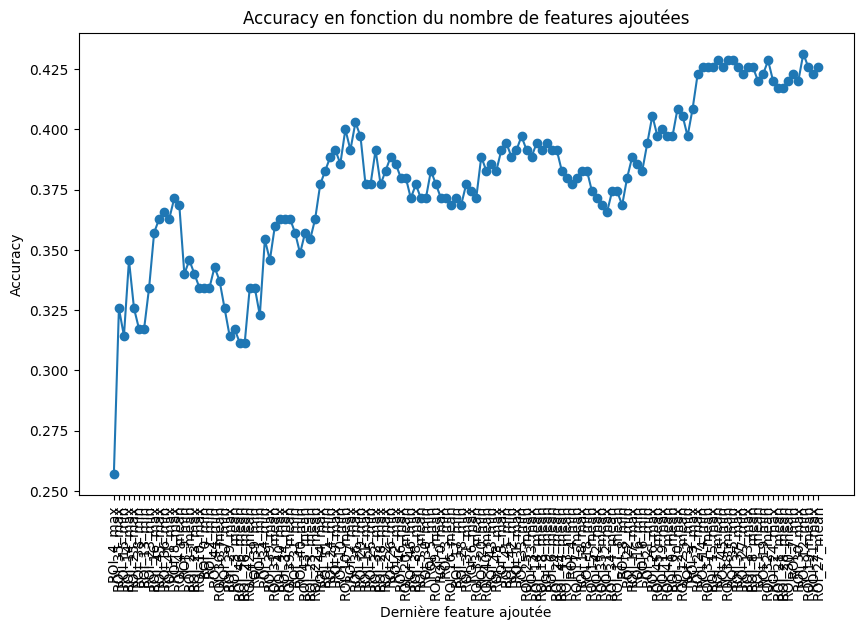

In [82]:
# # Tracer l'accuracy en fonction du nombre de features
# plt.figure(figsize=(10, 6))
# plt.plot(features_used, accuracies, marker='o')
# plt.xlabel('Dernière feature ajoutée')
# plt.ylabel('Accuracy')
# plt.xticks(rotation=90) # Pour améliorer la lisibilité des labels sur l'axe des x
# plt.title('Accuracy en fonction du nombre de features ajoutées')
# plt.show()

In [89]:
model = LogisticRegression(max_iter=1000)
ranking_df = pd.DataFrame()
for i in subject_numbers:
# Entraînement du modèle sur l'ensemble des données pour obtenir les coefficients
    model.fit(dict_df[f'sub_0{i}'][0], dict_df[f'sub_0{i}'][1])

    # Affichage des coefficients les plus importants
    coefficients = model.coef_[0]  # Pour la régression logistique binaire
    importance = np.abs(coefficients)

    # Affichage des caractéristiques et de leur importance relative, triées par importance
    features_importance = sorted(zip(dict_df[f'sub_0{i}'][0].columns, importance), key=lambda x: x[1], reverse=True)
    print(features_importance)
    feature_ranked = [feature[0] for feature in features_importance]
    ranking_df[f'sub-0{i}'] = feature_ranked


ranking_df

[('ROI_45_max', 0.8140489125832833), ('ROI_3_mean', 0.6098039769828365), ('ROI_12_min', 0.5115078629860454), ('ROI_28_max', 0.48760654362810596), ('ROI_43_min', 0.4864845962905948), ('ROI_37_min', 0.4794534415430443), ('ROI_26_min', 0.47869733899888584), ('ROI_13_max', 0.47637384984376224), ('ROI_24_max', 0.4646749062846122), ('ROI_10_min', 0.39331467055387265), ('ROI_44_max', 0.3856553206846401), ('ROI_35_max', 0.382724488770509), ('ROI_45_min', 0.3641496038325677), ('ROI_46_min', 0.3473301149400274), ('ROI_23_min', 0.33676711121989383), ('ROI_15_mean', 0.3362714302963936), ('ROI_33_mean', 0.3359978661784588), ('ROI_19_max', 0.3309465297726162), ('ROI_22_min', 0.3300069559108423), ('ROI_1_max', 0.3271373282428253), ('ROI_23_max', 0.306750720676474), ('ROI_38_min', 0.30666401743314314), ('ROI_0_max', 0.2897596454419996), ('ROI_2_mean', 0.28845431083886164), ('ROI_39_min', 0.27984626871303747), ('ROI_43_max', 0.2788196595492766), ('ROI_15_min', 0.268346758737662), ('ROI_15_max', 0.26786

,sub-03,sub-05,sub-06,sub-07,sub-08
0,ROI_45_max,ROI_41_min,ROI_24_max,ROI_23_max,ROI_26_min
1,ROI_3_mean,ROI_39_max,ROI_42_min,ROI_12_max,ROI_39_max
2,ROI_12_min,ROI_13_min,ROI_25_min,ROI_2_max,ROI_24_max
3,ROI_28_max,ROI_45_max,ROI_6_max,ROI_15_max,ROI_9_min
4,ROI_43_min,ROI_1_max,ROI_24_min,ROI_28_max,ROI_35_max
...,...,...,...,...,...
136,ROI_1_min,ROI_18_mean,ROI_40_mean,ROI_46_mean,ROI_41_mean
137,ROI_44_mean,ROI_7_mean,ROI_24_mean,ROI_44_mean,ROI_30_max
138,ROI_0_mean,ROI_25_min,ROI_3_max,ROI_13_max,ROI_45_min
139,ROI_11_mean,ROI_42_mean,ROI_45_min,ROI_32_mean,ROI_3_mean


In [97]:
# Concaténer les colonnes en une seule série tout en conservant les mêmes indices
concatenated = pd.concat([ranking_df[col] for col in ranking_df], ignore_index=False)

# Calculer la moyenne des indices pour chaque valeur unique de feature
mean_indices_for_features = concatenated.reset_index().groupby(0)['index'].mean()

# Trier les résultats par la moyenne des indices, de la plus faible à la plus élevée
sorted_features_by_mean_index = mean_indices_for_features.sort_values()
features_ordered = sorted_features_by_mean_index.index
features_ordered
# sorted_features_by_mean_index.head(10)  # Afficher les 10 features avec la moyenne d'indice la plus basse

Index(['ROI_24_max', 'ROI_3_min', 'ROI_10_min', 'ROI_45_max', 'ROI_18_min',
       'ROI_34_max', 'ROI_28_max', 'ROI_24_min', 'ROI_15_min', 'ROI_12_min',
       ...
       'ROI_7_min', 'ROI_18_mean', 'ROI_30_max', 'ROI_19_mean', 'ROI_30_min',
       'ROI_30_mean', 'ROI_17_mean', 'ROI_46_mean', 'ROI_31_mean',
       'ROI_11_mean'],
      dtype='object', name=0, length=141)

In [98]:
import copy
accuracies = []
features_used = []

for i in range(len(features_ordered)):
    features_to_use = features_ordered[:i+1]
    features_used.append(features_to_use[-1]) # Ajoute le nom de la dernière feature ajoutée
    dict_filtered = copy.deepcopy(dict_df)
    for sub in dict_filtered.values():
        sub[0] = sub[0][features_to_use]

    accuracy = mean_accuracy(dict_filtered)
    accuracies.append(accuracy)
    


In [100]:
features_ordered

Index(['ROI_24_max', 'ROI_3_min', 'ROI_10_min', 'ROI_45_max', 'ROI_18_min',
       'ROI_34_max', 'ROI_28_max', 'ROI_24_min', 'ROI_15_min', 'ROI_12_min',
       ...
       'ROI_7_min', 'ROI_18_mean', 'ROI_30_max', 'ROI_19_mean', 'ROI_30_min',
       'ROI_30_mean', 'ROI_17_mean', 'ROI_46_mean', 'ROI_31_mean',
       'ROI_11_mean'],
      dtype='object', name=0, length=141)

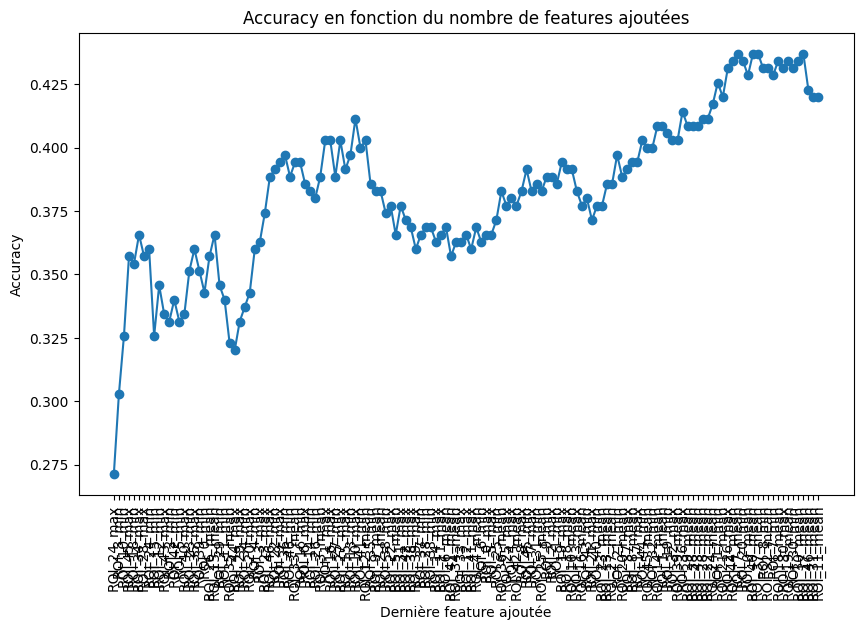

In [99]:
# Tracer l'accuracy en fonction du nombre de features
plt.figure(figsize=(10, 6))
plt.plot(features_used, accuracies, marker='o')
plt.xlabel('Dernière feature ajoutée')
plt.ylabel('Accuracy')
plt.xticks(rotation=90) # Pour améliorer la lisibilité des labels sur l'axe des x
plt.title('Accuracy en fonction du nombre de features ajoutées')
plt.show()